Ομάδα 91:

Δημήτρης Καλαθάς   03118016 <br>
Δημήτρης Καλέμης   03118152 <br>
Δημήτρης Μπακάλης  03118163 <br>

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install -U gensim

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy as sp
import gensim.downloader as api
from gensim.models import Word2Vec
import multiprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 91

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])
print(corpus[ID].lower())

['The Way of All Flesh']
['"Silent film",  "Drama",  "Indie",  "Black-and-white"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
movies_stopwords = stopwords.words('english')
movies_stopwords.extend(["movie", "film", "story", "plot", "era", "summary", "protagonist"])

Με τη συνάρτηση thorough_filter (αντίστοιχη με αυτή του notebook), αφαιρούμε από τα tokens, εκείνα τα οποία περιέχουν περισσότερα από ένα σημεία στίξης και όχι κάτι άλλο πέρα από σημείο στίξης. Επιπρόσθετα, ελέγχουμε και για συγκεκριμένα cases όπως το 's, το οποίο προκύπτει πολύ συχνά στα κείμενα περιγραφής ταινιών και ενδέχεται να επηρεάσει την ακρίβεια των συστάσεων.

In [ ]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
      if word == "'s":
        continue
      pun = []
      for letter in word:
        pun.append(letter in string.punctuation)
      if not all(pun):
        filtered_words.append(word)
    return filtered_words

Η συνάρτηση preprocess_corpus, χωρίζει σε tokens τη περιγραφή της ταινίας που παίρνει ως όρισμα, αφού πρώτα μετατρέψει όλα τα γράμματα σε πεζά. Στη συνέχεια, ελέγχει αν τα tokens είναι σημεία στίξης ή ανήκουν στο σύνολο english-stopwords και σε αυτή την περίπτωση, ξεσκαρτάρει τα tokens αυτά. Ακολουθήσαμε αυτό το σκεπτικό, από τη στιγμή που τα σημεία στίξης δεν εμπεριέχουν σημαντική πληροφορία για το περιεχόμενο της περιγραφής της ταινίας και θα μπορούσε να επηρεάσει αρνητικά τις προβλέψεις. Επίσης, λέξεις stopwords που είναι πολύ συχνές στο λόγο (πχ 'is', 'have', etc) για τον ίδιο λόγο αλλοιώνουν τη πρόβλεψη συναφών ταινιών βάση περιεχομένου. Έπειτα ο αλγόριθμος τρέχει για τα εναπομείναντα tokens τη διαδικασία thorough_filter, η οποία αναλύθηκε παραπάνω και τέλος πραγματοποιεί λημματοποίηση προκειμένου να δημιουργήσει σε όλα τα tokens κατάληλη κατάληξη. Είναι σημαντική η τελευταία διαδικασία ώστε λέξεις όπως play, plays, playing και played, οι οποίες αναφέρονται σε κάποιο παρόμοιο σημασιολογικό περιεχόμενο, ο υπολογιστής να τις καταλαβαίνει ως ίδιες και να μην προσθέτει επιπλέον διαστάσεις στην αναπαράσταση. Αξίζει να σημειώθει ότι δεν κάναμε stemming, καθώς αφαιρώντας τις καταλήξεις ορισμένων λέξεων, η συγκεκριμένη διαδικασία δημιουργούσε νέες λέξεις, που δεν υπάρχουν και κατ' επέκταση δεν χαρακτηρίζονται από κάποια αντιστοιχία με διάνυσμα στα προεκπαιδευμένα μοντέλα που χρησιμοποιήθηκαν.

In [ ]:
def preprocess_corpus(corpus):
    words = nltk.word_tokenize(corpus.lower())
    filtered_words = [word for word in words if word not in movies_stopwords + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    lem_words = [wordnet_lemmatizer.lemmatize(word) for word in filtered_words]
    corpus = ''
    for word in lem_words:
      corpus += word + ' '
    return corpus[:-1]

In [ ]:
preprocessed_corpus = [preprocess_corpus(summ) for summ in corpus]

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf_plain = vectorizer.transform(preprocessed_corpus).toarray()
print(corpus_tf_idf_plain.shape)

(5000, 44148)


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
def content_recommender(target_movie, max_recommendations, corpus_type):
  print('Recommended movies based on:', titles[target_movie], 'with genres:', categories[target_movie], '\n')
  
  cos_dists = []
  for i in range(corpus_type.shape[0]):
    cos_dist = sp.spatial.distance.cosine(corpus_type[i], corpus_type[target_movie]) #this is cosine distance not similarity  
    cos_dists.append(cos_dist) 

  ids_cos_sims = np.argsort(cos_dists) #max similarity = min distance
  ids_cos_sims = ids_cos_sims[1:max_recommendations+1]
  
  print('{:<20} {:<10} {:<60} {:<100} {}'.format('Similarity', 'Movie ID', 'Movie title(s)', 'Movie categories', 'Movie summaries'))
  print(210*'=')
  for id in ids_cos_sims:
    print('{:<20} {:<10} {:<60} {:<100} {}'.format(1-cos_dists[id], id, ','.join(titles[id]), ','.join(categories[id]), ','.join(summaries[id])))

In [ ]:
content_recommender(999, 10, corpus_tf_idf_plain)

Recommended movies based on: ['The Way of All Flesh'] with genres: ['"Silent film",  "Drama",  "Indie",  "Black-and-white"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.21780007016317815  1241       The Pilgrim                                                  "Silent film",  "Indie",  "Black-and-white",  "Comedy"                                               Chaplin plays an escaped convict who steals a minister's clothes to get out of his prison uniform. He ends up in a small town mistaken for a parson, and accepts a position at the local church. The Pilgrim's true identity is revealed when he tries to get a fellow crook to return money the crook stole from the Pilgrim's landlady. But rather than incarcerate the Pilgrim, the sheriff releases him at the Mexican border.
0.20574973853446266  4987       Unnai Ninaithu    

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




**Βελτιστοποίηση Παραμέτρων TfidfVectorizer**<br>
Με τη χρήση της TfidfVectorizer, κάθε διαφορετική λέξη στο προεπεξεργασμένο λεξιλόγιο μας καταλαμβάνει μια διάσταση. Αρχικά, είχαμε τις default παραμέτρους του TfidfVectorizer, ενώ τώρα τροποποιώντας τις παραμέτρους max_df και min_df παίρνουμε καλύτερα αποτελέσματα συστάσεων. Πιο συγκεκριμένα, θέτουμε max_df=0.5, δηλαδή αγνοούμε τους όρους με συχνότητα μεγαλύτερη από 50% και min_df=20, δηλαδή αγνοούμε τους όρους που εμφανίζονται λιγότερο από 20 φορές. Ως αποτέλεσμα, όχι μόνο μειώνουμε την διαστατικότητα του προβλήματος (που οδηγεί σε λιγότερη υπολογιστική πολυπλοκότητα), αλλά ταυτόχρονα διώχνουμε επιπλέον stopwords (με το max_df) και σπάνια tokens (με το min_df) που εισάγουν θόρυβο στις προβλέψεις παρόμοιων ταινιών. Εκ του αποτελέσματος, φαίνεται παρακάτω πως η δεύτερη εκδοχή του recommender έχει υψηλότερες τιμές similarity, το οποίο σημαίνει πως με μεγαλύτερη βεβαιότητα το σύστημά μας προτείνει αντίστοιχες ταινίες με βάση την ομοιότητα περιεχομένου.

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df = 20)
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf_plain = vectorizer.transform(preprocessed_corpus).toarray()
print(corpus_tf_idf_plain.shape)

(5000, 4606)


In [ ]:
content_recommender(999, 10, corpus_tf_idf_plain)

Recommended movies based on: ['The Way of All Flesh'] with genres: ['"Silent film",  "Drama",  "Indie",  "Black-and-white"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.21780007016317815  1241       The Pilgrim                                                  "Silent film",  "Indie",  "Black-and-white",  "Comedy"                                               Chaplin plays an escaped convict who steals a minister's clothes to get out of his prison uniform. He ends up in a small town mistaken for a parson, and accepts a position at the local church. The Pilgrim's true identity is revealed when he tries to get a fellow crook to return money the crook stole from the Pilgrim's landlady. But rather than incarcerate the Pilgrim, the sheriff releases him at the Mexican border.
0.20574973853446266  4987       Unnai Ninaithu    

###Cherry-picking Examples


In [ ]:
content_recommender(7, 10, corpus_tf_idf_plain)

Recommended movies based on: ['Earth vs. the Spider'] with genres: ['"Thriller",  "Science Fiction",  "Horror"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.3219203010728876   631        Spider-Man 2                                                 "Thriller",  "Science Fiction",  "Superhero movie",  "Superhero",  "Action/Adventure",  "Drama",  "Fantasy",  "Action"   Peter Parker struggles to balance his crime-fighting duties as Spider-Man with the demands of his normal life. Parker is estranged from both love interest Mary Jane Watson and best friend Harry Osborn, who still harbors a resentment against Spider-Man. His obligations as Spider-Man bear a burden on his ability to focus on his academic life as well as his financial situation. As a result, Peter starts to think about giving up being Spider-Man. Harry, now hea

Οι κατηγορίες των προτεινόμενων ταινιών είναι πολύ κοντά στις κατηγορίες της ταινίας που δώσαμε ως είσοδο. Πιο συγκεκριμένα, παίρνουμε με μεγάλο similarity (της τάξης του 0.3) πολύ συναφή ταινίες με αυτή που θέλουμε τόσο με γνώμονα τα categories (thriller, science fiction).

In [ ]:
content_recommender(2002, 10, corpus_tf_idf_plain)

Recommended movies based on: ["The Stranger's Return"] with genres: ['"Romance Film",  "Drama"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.2312459227683562   4514       Picking Up & Dropping Off                                    "Romance Film",  "Drama",  "Comedy"                                                                  A divorced father and a divorced mother start to meet at Denver International Airport when picking up and sending off their children to ex-spouses for holidays.
0.18747644666624352  1285       Action Replayy                                               "Romantic comedy",  "Science Fiction",  "World cinema",  "Musical",  "Drama",  "Comedy",  "Romantic drama",  "Romance Film",  "Bollywood" The story focuses on Kishen , a well-to-do businessman, who is unhappily married to Mala . They have a gr

Στο παράδειγμα αυτό 9 στις 10 ταινίες που προτείνονται έχουν τουλάχιστον ένα κοινό είδος με την αρχική ταινία. Ακόμη, οι δύο πιο υψηλές σε ομοιότητα ταινίες, έχουν και τα δύο είδη (Romance Film, Drama) στο category list τους, συνεπώς είναι καλές συστάσεις.

###Nit-picking Examples


In [ ]:
content_recommender(566, 10, corpus_tf_idf_plain)

Recommended movies based on: ['Kagbeni'] with genres: ['"Horror"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.5594896481471991   2201       Thillalangadi                                                "Short Film",  "Action",  "Comedy"                                                                   Krishna  is a happy-go-lucky youth who excels in every field, but always does strange and dangerous things to obtain a certain "kick"- a thrill or excitement that he craves. One such activity is secretly double-crossing his childhood friend Dass ([[Sathyan  while helping him elope. At this point, he meets Nisha  who is shocked at his recklessness and writes him off as crazy. Krishna, however, sets his sights on Nisha and woos her in a very unorthodox way; he begs her not to fall in love with him. After a host of comical s

Παρόλο που έχουμε πολύ υψηλές τιμές similarity (πάνω από 0.5) με βάση το περιεχόμενο της περιγραφής, οι ταινίες που προτείνονται ανήκουν σε εντελώς διαφορετικό είδος. Πιο αναλυτικά, η ταινία εισόδου είναι μια ταινία τρόμου, ενώ προτείνονται κωμωδίες με similarity 0.55. Επιπλέον, καμία από τις 10 προτεινόμενες ταινίες δεν είναι horror film, ενώ έχουμε συνολικά 5 προτεινόμενες κωμωδίες, 1 musical και 1 οικογενειακή ταινία, δηλαδή άστοχες συστάσεις με βάση την ταινία Kagbeni.

In [ ]:
content_recommender(3379, 10, corpus_tf_idf_plain)

Recommended movies based on: ['Disturbed'] with genres: ['"Horror"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.4184216528175597   22         Weekend                                                      "Romance Film",  "Drama"                                                                             On a Friday night in Nottingham, after a drunken house party with his friends, Russell ([[Tom Cullen  heads out to a gay club, alone and looking for an encounter. Just before closing time he picks up Glen , an aspiring artist, and they end up sleeping together back in Russell's apartment. Russell, who works as a lifeguard, feels inferior about his job. The next day Glen and Russell meet up and the two ride Russell's bike together. Back at Russell's apartment, they spend the day together, sharing stories of their past en

Η ταινία εισόδου είναι και πάλι μια ταινία τρόμου. Παρόλα αυτά, με μεγάλο similarity προτείνονται ταινίες romance και drama. Μόνο δύο συστάσεις ταινιών είναι horror, επομένως με αφάλεια μπορούμε να πούμε πως οι συστάσεις δεν είναι καλές. 

###Πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf

**Πλεονεκτήματα**<br>
* Εύκολος και γρήγορος υπολογισμός similarity μεταξύ δύο documents χρησιμοιποιώντας τις αναπαραστάσεις
* Έχουμε κάποιες βασικές μετρικές αναφορικά με τους περιγραφικούς όρους-λέξεις μιας εγγραφής (document)
* Εύκολος υπολογισμός tf (text frequency) και idf (inverse document frequency).
* Σημαντικά λιγότερος χρόνος σε σχέση με το Word2Vec μοντέλο.

**Μειονεκτήματα**<br>
* Οι αναπαραστάσεις tf-idf βασίζονται στο μοντέλο bag-of-words (BoW), συνεπώς αδυνατούν να συμπεριλάβουν τη θέση των λέξεων στο κείμενο και τη σημασιολογία εντός ενός αρχείου.
* Το μοντέλο tf-idf δεν αξιοποιεί τη σημασιολογία των λέξεων μέσα σε ένα κείμενο, αλλά περιορίζεται αποκλειστικά σε στατιστικές ιδιότητες των εμφανίσεων των λέξεων.
* Οι πίνακες που δημιουργούνται με το μοντέλο tf-idf είναι αραιοί (sparse), με αποτέλεσμα να δεσμεύεται πολλή μνήμη για αποθήκευση λίγης πληροφορίας.

Πηγή: https://www.quora.com/What-are-the-advantages-and-disadvantages-of-TF-IDF

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
w2v_model = api.load('word2vec-google-news-300')

[=================================================-] 99.9% 1660.6/1662.8MB downloaded


In [ ]:
def build_tfw2v(corpus, model, embeddings_size):

  vectorizer = TfidfVectorizer(max_df=0.5, min_df = 20)
  tfidfs = vectorizer.fit_transform(corpus)

  new_corpus = []

  for idx1, summary in enumerate(corpus):
    words = nltk.word_tokenize(summary)
    sum_tfidfs = 0
    wsum_w2v = embeddings_size*[0]

    for word in words:
      try:
        vector = model[word]

        if word in vectorizer.vocabulary_:
          idx2 = vectorizer.vocabulary_[word]
          tfidf = tfidfs[idx1, idx2]
        
        else:
          continue 
      
        sum_tfidfs += tfidf
        wsum_w2v += tfidf*vector

      except:
        continue

    new_corpus.append(np.array(wsum_w2v)/sum_tfidfs)
  
  return np.array(new_corpus)

In [ ]:
new_corpus = build_tfw2v(preprocessed_corpus, w2v_model, 300)

In [ ]:
content_recommender(999, 10, new_corpus)

Recommended movies based on: ['The Way of All Flesh'] with genres: ['"Silent film",  "Drama",  "Indie",  "Black-and-white"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.8796891617124624   1241       The Pilgrim                                                  "Silent film",  "Indie",  "Black-and-white",  "Comedy"                                               Chaplin plays an escaped convict who steals a minister's clothes to get out of his prison uniform. He ends up in a small town mistaken for a parson, and accepts a position at the local church. The Pilgrim's true identity is revealed when he tries to get a fellow crook to return money the crook stole from the Pilgrim's landlady. But rather than incarcerate the Pilgrim, the sheriff releases him at the Mexican border.
0.8391121610588295   2300       Tais-toi!         

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


Αρχικά, συγκρίνουμε τις αναπαραστάσεις word embeddings συγκριτικά με τις αναπαραστάσεις tf-idf. Παίρνουμε κάποιες από τις παραπάνω περιπτώσεις id που εξετάσαμε με το μοντέλο tf-idf και παίρνουμε τις αντίστοιχες προτεινόμενες ταινίες με τη χρήση του Word2Vec. Πιο συγκεκριμένα, παίρνουμε το id=7 (Earth vs. the Spider), στο οποίο μεν είχαμε καλές συστάσεις με το tf-idf, αλλά οι περισσότερες προτεινόμενες ταινίες εστίασαν υπερβολικά στη λέξη spider και πρότειναν 4 στις 10 ταινίες με τίτλο σχετικό με αράχνες (spider-man, tarantula, giant spider, etc). Με το μοντέλο Word2Vec, όπως φαίνεται παρακάτω, έχουμε ακόμη μεγαλύτερο ποσοστό καλών συστάσεων και επιπλέον έχουμε αποφύγει την εστίαση στη λέξη spider, από τη στιγμή που μόνο 2 στις 10 προτεινόμενες ταινίες έχουν στο τίτλο και τη περιγραφή τους τη λέξη αυτή. Συμπεραίνουμε, λοιπόν, πως η υλοποίηση Word2Vec έχει ενσωματώσει τη σημασιολογία της περιγραφής της ταινίας εισόδου και δεν επηρεάζεται μόνο από στατιστικές ιδιότητες των εμφανίσεων των λέξεων. 

In [ ]:
content_recommender(7, 10, new_corpus)

Recommended movies based on: ['Earth vs. the Spider'] with genres: ['"Thriller",  "Science Fiction",  "Horror"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.8446778472720129   4948       Laserhawk                                                    "Thriller",  "Alien Film",  "Science Fiction",  "Teen"                                               Nerdy Wisconsin teen Zach Raymond  gains fame in his area and at high school after allegedly videotaping a UFO with unprecedented quality. Soon, however, Col. Lewis Teagarden of the United States Army comes to investigate his claim, and he discovers that Zach faked the footage using a green screen and a homemade UFO model. Dejected and outed as a fraud, Zach gets a job at a local diner and there meets Cara , a goth girl who is also a huge comic book fan. She tells him he shoul

Στη συνέχεια, εξετάζουμε μια περίπτωση nit-picking για τον tf-idf. Πιο αναλυτικά, η ταινία Disturbed με id=3379, είχε μόνο 2 καλές συστάσεις με τη χρήση του μοντέλου tf-idf. Παρακάτω, φαίνονται οι συστάσεις με βάση την ίδια ταινία που δίνει ο Word2Vec recommender. Είναι προφανές ότι δίνει πολύ καλύτερα αποτελέσματα, από τη στιγμή που προτείνει 5 ταινίες horror. Τα word embeddings, συνεπώς, φαίνεται να αντιλαμβάνονται καλύτερα το σημασιολογικό περιεχόμενο (semantic context) των κειμένων, σε αντίθεση με τα tf-idf που στο συγκεκριμένο παράδειγμα παραπλανήθηκαν από την εμφάνιση λέξεων, όπως daughter, rape κλπ και πρότειναν ταινίες drama και romance.

In [ ]:
content_recommender(3379, 10, new_corpus)

Recommended movies based on: ['Disturbed'] with genres: ['"Horror"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.7446565651839333   3904       The Rape of Richard Beck                                     "Crime Fiction",  "Drama",  "Television movie"                                                       Richard Beck  is a police detective who believed that rape victims are to blame for the crime. He is later raped by two of the suspects he had been chasing. Ultimately, he changes his beliefs about rape victims. This made for TV movie was groundbreaking in that it portrayed the rape of a man by two other men, and because of this it has become a cult classic.
0.7419726809664937   575        Shrooms                                                      "Cult",  "Horror",  "Indie",  "Slasher"                                

Ακόμη, εξετάζουμε μια περίπτωση όπου είχαμε nit-picking με το tf-idf μοντέλο με την ταινία Kagbeni (id=566). Όπως φαίνεται και παρακάτω, ο Word2Vec δε δίνει καλύτερα αποτελέσματα σε σχέση με τον tf-idf, αφού και πάλι δε προτείνει ταινίες horror, αλλά κωμωδίες, musical και ρομαντικές ταινίες. Επομένως, ακόμα και με τη χρήση των embeddings, υπάρχουν περιπτώσεις nit-picking, στις οποίες τα αποτελέσματα δεν είναι ικανοποιητικά.

In [ ]:
content_recommender(566, 10, new_corpus)

Recommended movies based on: ['Kagbeni'] with genres: ['"Horror"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.8952248959388955   1938       Thodu Dongalu                                                "Comedy film",  "Action"                                                                             Krishna  and Kishore  are friends who play tricks on every possible person to make their living. The movie starts with kishore creating nuisance in a bar and krishna bargaining with that bar owner to handle this issue. Later they plan to make money by creating fake accident, but kishore gets attracted towards Jaya , who is driving that car and forget his purpose. Krishna meets Rekha, and falls in love with her. Rekha works for Rao  and Reddy because, they’ve captivated her father to know secrets about a treasure. Krishna 

Εκτός των ποιοτικών χαρακτηριστικών, η αναπαράσταση με word embeddings είναι πιο συμφέρουσα από πλευρά μνήμης από την αναπαράσταση με tf-idf. Αυτό συμβαίνει, αφού οι αναπαραστάσεις με τα word embeddings είναι πυκνές (dense) σε αντίθεση με τις δεύτερες οι οποίες είναι αραιές (dense). 


Όμως η χρήση των word embeddings επιφέρει αντίστοιχα και κάποια μειονεκτήματα:<br>
* Περιορισμός στις in-vocabulary λέξεις, οπότε θέλουμε υποχρεωτικά μεγάλο λεξικό λέξεων
* Τεράστιο dataset από κείμενα για την εκπαίδευση των διανυσματικών αναπαραστάσεων. Τεχνική transfer learning λύνει εν μέρει το πρόβλημα αυτό, αφού δε χρειάζεται να έχουμε το μεγάλο αυτό dataset (ούτε και να πραγματοποιήσουμε εμείς οι ίδιοι την εκπαίδευση). Ωστόσο, η εκπαίδευση πάνω στο δικό μας corpus είναι μια διαδικασία που απαιτεί αρκετό χρόνο σε σχέση με το tf-idf vectorizer
* Δεν είναι σπάνιο φαινόμενο, σημασιολογικά σντίθετες λέξεις να βρίσκονται σε πολύ κοντινά σημεία του διανυσματικού χώρου των αναπαραστάσεων. Αυτό συμβαίνει, από τη στιγμή που το context γύρω από αυτές τις λέξεις μπορεί να είναι παρόμοιο και απλώς να αντιστρέφεται η έννοια της πρότασης. Αυτό προκαλεί μεγάλη σύγχυση στην οργάνωση κειμένων ως προς το περιεχόμενο, κυρίως όταν έχουμε sentiment analysis

Πηγή: https://www.quora.com/What-are-the-advantages-and-disadvantages-of-Word2vec-and-GloVe

##Further testing, Smaller embeddings

Επιπλέον, συγκρίνουμε τα ποιοτικά αποτελέσματα μεταξύ δύο διαφορετικών αναπαραστάσεων Word2Vec. Η πρώτη αναπαράσταση είναι αυτή που χρησιμοποιήθηκε παραπάνω με 300 διαστάσεις, ενώ τώρα φορτώνουμε πάλι με transfer learning ένα πιο μικρό μοντέλο 25 διαστάσεων:

In [ ]:
model_25 = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
tfw2v_corpus25 = build_tfw2v(preprocessed_corpus, model_25, 25)

Παρακάτω φαίνονται οι προτεινόμενες ταινίες με βάση τη ταινία Disturbed (id=3379), η οποία εξετάστηκε και προηγουμένως με τον 300 διαστάσεων Word2Vec:

In [ ]:
content_recommender(3379, 10, tfw2v_corpus25)

Recommended movies based on: ['Disturbed'] with genres: ['"Horror"'] 

Similarity           Movie ID   Movie title(s)                                               Movie categories                                                                                     Movie summaries
0.9786365695783189   3197       The Astronaut's Wife                                         "Thriller",  "Science Fiction",  "Horror",  "Indie",  "Sci-Fi Horror",  "Psychological thriller"     Spencer Armacost  is a NASA astronaut. While on a space-walking mission with fellow astronaut Alex Streck, an explosion results in a communication loss for two minutes between the astronauts and Earth. After returning to their respective spouses, the two astronauts never speak about their ordeal and Streck grows increasingly hostile towards Armacost, constantly saying that he is not his friend. Not long after their return, Streck bleeds to death during a party. His death is ruled as a rare hemorrhagic stroke by NASA. Wh

Εκ του αποτελέσματος, παίρνουμε μόνο 2 horror movies με το νέο Word2Vec μοντέλο, σε αντίθεση με το 300-dimensional, με τη χρήση του οποίου πήραμε 5 καλές συστάσεις. Αξίζει να σημειωθεί, πως ακόμα και με τη χρήση της 25-dimension Word2Vec αναπαράστασης έχουμε καλύτερες συστάσεις από την tf-idf στη συγκεκριμένη περίπτωση. Συμπεραίνουμε, επομένως, ότι με την αύξηση της διάστασης των word embeddings, πραγματοποιείται καλύτερη σύλληψη του σημασιολογικού περιεχομένου του κειμένου και άρα προτείνονται πιο όμοιες ταινίες. Ταυτόχρονα, όμως, με τη χρήση διανυσματικών αναπαραστάσεων πολύ μεγάλης διαστατικότητας, έχουμε πολύ μεγάλους χρόνους εκπαίδευσης για το training του δικού μας corpus.

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
import joblib

joblib.dump(new_corpus, 'corpus_tfidf_w2v.pkl') 

['corpus_tfidf_w2v.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

total 12M
-rw-r--r-- 1 root root  12M Jan  2 13:26 corpus_tfidf_w2v.pkl
drwxr-xr-x 1 root root 4.0K Dec 20 20:19 sample_data


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set(new_corpus)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
final_set.shape

(5000, 622)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [ ]:
final_set = final_set[:2000, :]
n_rows, n_columns = 10, 10
som10 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som10.train(final_set, epochs = 100)

CPU times: user 47.4 s, sys: 332 ms, total: 47.7 s
Wall time: 44.3 s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
bmus10 = som10.bmus
print(bmus10.shape)

ubmus10, indices10 = np.unique(bmus10, return_inverse=True, axis=0)
print(ubmus10)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans

som10.cluster(algorithm=KMeans(n_clusters=20, n_init=10))


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



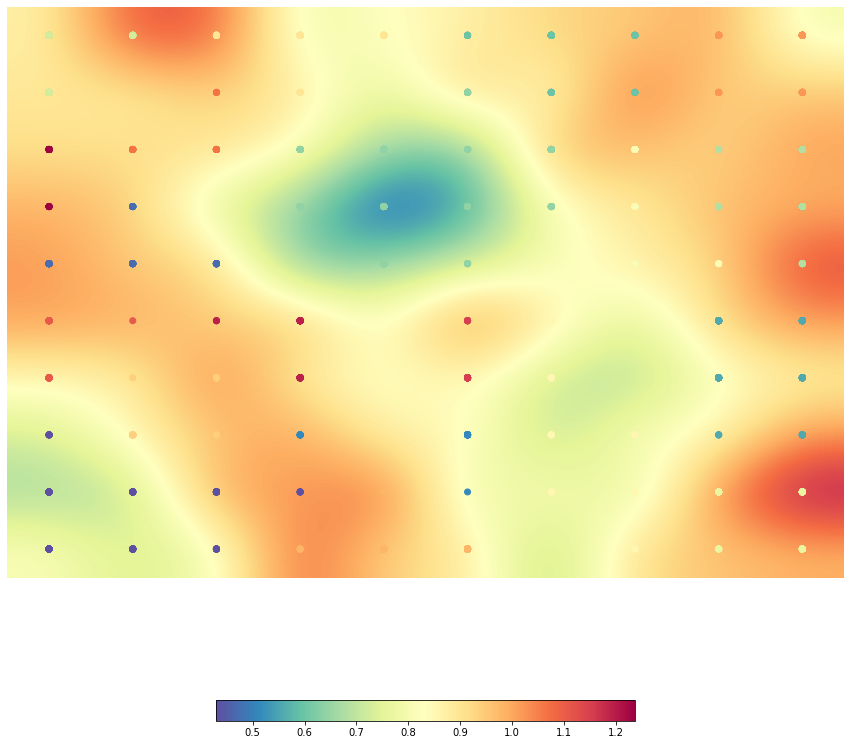

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som10.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
print(som10.clusters)

[[ 7  7 11 11 11  4  4  4 14 14]
 [ 7  7 15 11  5  5  4  4 14 14]
 [19 15 15  5  5  5  5  9  6  6]
 [19  1 15  5  5  5  5  9  6  6]
 [ 1  1  1  5  5  5  9  9  9  6]
 [16 16 18 18 18 17 10  9  3  3]
 [16 12 12 18  2 17 10 10  3  3]
 [ 0 12 12  2  2  2 10 10  3  3]
 [ 0  0  0  0 13  2 10 10  8  8]
 [ 0  0  0 13 13 13 10 10  8  8]]


In [ ]:
clusters, neurons_num = np.unique(som10.clusters, return_counts = True)
sorted_cluster_idxs = np.argsort(neurons_num)

print("Clusters sorted by inreasing number of neurons:")
print("Cluster index    :", sorted_cluster_idxs)
print("Number of neurons:", neurons_num[sorted_cluster_idxs])

Clusters sorted by inreasing number of neurons:
Cluster index    : [19 17 16  1  7  8 18 15 11 12 13 14  2  4  6  9  3  0 10  5]
Number of neurons: [ 2  2  3  4  4  4  4  4  4  4  4  4  5  5  5  6  6  8  9 13]



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
def print_categories_stats(ids):
  total_categories = []
  for id in ids:
    movie_categories = [cat_list.strip().strip('"') for cat_list in categories[id][0].split(',')]  
    total_categories.extend(movie_categories)
  
  categories_, cat_frequency = np.unique(total_categories, return_counts = True)
  categories_idxs = np.argsort(cat_frequency)[::-1]

  print('Overall Cluster Genres stats:')

  stats = []
  for category, frequency in zip(categories_[categories_idxs], cat_frequency[categories_idxs]):
    stats.append((category, frequency))
  
  print(stats)

In [ ]:
def print_cluster_neurons_movies_report(cluster, map, ubmus):
  coords = np.where(map.clusters == cluster)
  coords = np.column_stack((coords[0], coords[1]))

  idxs = []
  for coord in coords:
    if coord[::-1] in ubmus:
      idxs.append(10*coord[0] + coord[1])

  return np.array(idxs)

In [ ]:
def neuron_movies_report(neurons_list, indices):
  
  ids = []
  for neuron in neurons_list:
    ids.extend(list(np.where(neuron == indices)[0]))

  print_categories_stats(ids)

In [ ]:
cluster = 5
neurons_list = print_cluster_neurons_movies_report(cluster, som10, ubmus10)
neuron_movies_report(neurons_list, indices10)

Overall Cluster Genres stats:
[('Comedy', 68), ('Comedy film', 54), ('Drama', 52), ('Black-and-white', 39), ('Action/Adventure', 39), ('Romance Film', 35), ('Action', 35), ('Adventure', 21), ('Crime Fiction', 16), ('Musical', 15), ('Silent film', 15), ('Indie', 13), ('Romantic comedy', 10), ('Science Fiction', 9), ('Horror', 7), ('Mystery', 7), ('Western', 7), ('Martial Arts Film', 6), ('Family Film', 6), ('Parody', 6), ('Crime Comedy', 6), ('Comedy-drama', 5), ('Cult', 5), ('Melodrama', 5), ('World cinema', 5), ('Teen', 5), ('Adventure Comedy', 5), ('War film', 4), ('Action Comedy', 4), ('Swashbuckler films', 4), ('Heist', 4), ('Biopic [feature]', 4), ('Chinese Movies', 4), ('Biographical film', 3), ('Disaster', 3), ('Slapstick', 3), ('Historical fiction', 3), ('Short Film', 3), ('Comedy of Errors', 3), ('Buddy film', 3), ('Fantasy', 3), ('Period piece', 3), ('Film noir', 2), ('Animation', 2), ('Family Drama', 2), ('Black comedy', 2), ('Caper story', 2), ('Film adaptation', 2), ('Fant


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


Παρακάτω φαίνονται τα στατιστικά για ολόκληρο το υποσύνολο του dataset (2000 ταινίες) που χρησιμοποιήθηκε για την εκπαίδευση:

In [ ]:
ids = [i for i in range(2000)]
print_categories_stats(ids)

Overall Cluster Genres stats:
[('Drama', 911), ('Comedy', 510), ('Romance Film', 339), ('Thriller', 299), ('Action', 282), ('World cinema', 242), ('Crime Fiction', 222), ('Horror', 196), ('Action/Adventure', 183), ('Indie', 180), ('Black-and-white', 175), ('Adventure', 139), ('Short Film', 139), ('Family Film', 136), ('Romantic drama', 132), ('Musical', 112), ('Romantic comedy', 108), ('Mystery', 106), ('Animation', 103), ('Comedy film', 102), ('Science Fiction', 96), ('Fantasy', 88), ('Crime Thriller', 85), ('War film', 81), ('Japanese Movies', 67), ('Comedy-drama', 64), ('Bollywood', 61), ('Chinese Movies', 59), ('Documentary', 56), ('Film adaptation', 55), ('Silent film', 54), ('Period piece', 52), ('Western', 50), ('Family Drama', 45), ('Teen', 43), ('Parody', 39), ('Television movie', 37), ('Black comedy', 37), ("Children's/Family", 36), ('Slasher', 36), ('Sports', 36), ('Martial Arts Film', 34), ('Psychological thriller', 34), ('Coming of age', 34), ('Cult', 34), ('Satire', 30), 

Παρατηρούμε πως οι κύριες κατηγορίες ταινιών, που εκπροσωπούνται στο συγκεκριμένο dataset είναι οι Drama, Comedy, Romance Film, Thriller, Action, World Cinema και Crime Fiction. Αυτό, όπως θα δούμε και στα πειράματα παρακάτω, αποτυπώνεται και στο clustering, καθώς τα clusters που περιέχουν τους περισσότερους νευρώνες, αποτελούνται, κυρίως, από τις συγκεκριμένες κατηγορίες ταινιών.

Στη συνέχεια, θα εξάγουμε τα στατιστικά για ορισμένα clusters του χάρτη και θα επιχειρήσουμε να βγάλουμε συμπεράσματα σχετικά 

In [ ]:
cluster = 5
neurons_list = print_cluster_neurons_movies_report(cluster, som10, ubmus10)
neuron_movies_report(neurons_list, indices10)

Overall Cluster Genres stats:
[('Comedy', 68), ('Comedy film', 54), ('Drama', 52), ('Black-and-white', 39), ('Action/Adventure', 39), ('Romance Film', 35), ('Action', 35), ('Adventure', 21), ('Crime Fiction', 16), ('Musical', 15), ('Silent film', 15), ('Indie', 13), ('Romantic comedy', 10), ('Science Fiction', 9), ('Horror', 7), ('Mystery', 7), ('Western', 7), ('Martial Arts Film', 6), ('Family Film', 6), ('Parody', 6), ('Crime Comedy', 6), ('Comedy-drama', 5), ('Cult', 5), ('Melodrama', 5), ('World cinema', 5), ('Teen', 5), ('Adventure Comedy', 5), ('War film', 4), ('Action Comedy', 4), ('Swashbuckler films', 4), ('Heist', 4), ('Biopic [feature]', 4), ('Chinese Movies', 4), ('Biographical film', 3), ('Disaster', 3), ('Slapstick', 3), ('Historical fiction', 3), ('Short Film', 3), ('Comedy of Errors', 3), ('Buddy film', 3), ('Fantasy', 3), ('Period piece', 3), ('Film noir', 2), ('Animation', 2), ('Family Drama', 2), ('Black comedy', 2), ('Caper story', 2), ('Film adaptation', 2), ('Fant

In [ ]:
cluster = 10
neurons_list = print_cluster_neurons_movies_report(cluster, som10, ubmus10)
neuron_movies_report(neurons_list, indices10)

Overall Cluster Genres stats:
[('Animation', 42), ('Fantasy', 34), ('Family Film', 34), ('Japanese Movies', 25), ('Adventure', 21), ("Children's/Family", 21), ('Horror', 16), ("Children's", 15), ('World cinema', 15), ('Comedy', 14), ('Action', 14), ('Science Fiction', 13), ('Drama', 12), ("Children's Fantasy", 8), ('Family-Oriented Adventure', 6), ('Anime', 5), ('Mystery', 5), ('Musical', 4), ('Television movie', 4), ('Animal Picture', 4), ('Romance Film', 4), ('Chinese Movies', 4), ('Sports', 4), ('Computer Animation', 3), ('Creature Film', 3), ('Monster', 3), ('Stop motion', 3), ('Animated cartoon', 3), ('Indie', 3), ('Music', 3), ('Comedy film', 2), ('Animated Musical', 2), ('Fantasy Adventure', 2), ('Zombie Film', 2), ('Teen', 2), ('Short Film', 2), ('Filipino Movies', 1), ('History', 1), ('Time travel', 1), ('Sword and sorcery', 1), ('Surrealism', 1), ('Supernatural', 1), ('Splatter film', 1), ('Auto racing', 1), ('Black-and-white', 1), ('Buddy film', 1), ('Silent film', 1), ('Rom

In [ ]:
cluster = 0
neurons_list = print_cluster_neurons_movies_report(cluster, som10, ubmus10)
neuron_movies_report(neurons_list, indices10)

Overall Cluster Genres stats:
[('Thriller', 99), ('Action', 80), ('Action/Adventure', 76), ('Crime Fiction', 58), ('Crime Thriller', 38), ('Drama', 29), ('Action Thrillers', 19), ('Horror', 13), ('World cinema', 13), ('Mystery', 12), ('Adventure', 11), ('Science Fiction', 11), ('Indie', 9), ('Comedy', 8), ('Gangster Film', 8), ('Martial Arts Film', 7), ('Psychological thriller', 6), ('Japanese Movies', 6), ('Superhero movie', 5), ('Chase Movie', 4), ('Chinese Movies', 4), ('Detective', 4), ('Sports', 4), ('Fantasy', 4), ('Superhero', 4), ('Spy', 4), ('B-movie', 3), ('Natural horror films', 3), ('Black-and-white', 3), ('Black comedy', 3), ('Suspense', 3), ('Cult', 3), ('Detective fiction', 3), ('Creature Film', 2), ('Romance Film', 2), ('Crime Drama', 2), ('Disaster', 2), ('Buddy film', 2), ('Doomsday film', 2), ('Auto racing', 2), ('Period piece', 2), ('Film adaptation', 2), ('Glamorized Spy Film', 2), ('Heist', 2), ('War film', 2), ('Art film', 1), ('Airplanes and airports', 1), ('Bik

In [ ]:
cluster = 15
neurons_list = print_cluster_neurons_movies_report(cluster, som10, ubmus10)
neuron_movies_report(neurons_list, indices10)

Overall Cluster Genres stats:
[('Drama', 96), ('Romance Film', 50), ('Comedy', 39), ('Comedy film', 23), ('Family Film', 14), ('Adventure', 9), ("Children's/Family", 8), ('Action', 7), ('Crime Fiction', 6), ('Bollywood', 5), ('Fantasy', 5), ('Musical', 5), ('Comedy-drama', 4), ('Sports', 3), ('Melodrama', 3), ('Film adaptation', 3), ('Japanese Movies', 3), ('Heavenly Comedy', 2), ('Indie', 2), ('Black-and-white', 2), ('Fantasy Comedy', 2), ('Mystery', 2), ('Science Fiction', 2), ('Childhood Drama', 2), ('Teen', 2), ('Family Drama', 2), ('Coming of age', 2), ('Crime Comedy', 1), ('Black comedy', 1), ('Animal Picture', 1), ('Cult', 1), ('Caper story', 1), ('Buddy film', 1), ('Boxing', 1), ('Chinese Movies', 1), ('War film', 1), ('Escape Film', 1), ('Feminist Film', 1), ('Swashbuckler films', 1), ('Silent film', 1), ('Romantic comedy', 1), ('Religious Film', 1), ('Prison', 1), ('Pre-Code', 1), ('Political drama', 1), ('Political cinema', 1), ('Period piece', 1), ('Parody', 1), ('Musical c

In [ ]:
cluster = 8
neurons_list = print_cluster_neurons_movies_report(cluster, som10, ubmus10)
neuron_movies_report(neurons_list, indices10)

Overall Cluster Genres stats:
[('Family Film', 37), ('Animation', 37), ('Short Film', 31), ('Comedy', 11), ('Comedy film', 9), ('Western', 4), ('Science Fiction', 2), ('Superhero movie', 1), ('Romance Film', 1), ('Mystery', 1), ('Computer Animation', 1), ('Adventure', 1), ('Action/Adventure', 1)]


In [ ]:
cluster = 12
neurons_list = print_cluster_neurons_movies_report(cluster, som10, ubmus10)
neuron_movies_report(neurons_list, indices10)

Overall Cluster Genres stats:
[('Thriller', 28), ('Drama', 23), ('Action', 22), ('Crime Fiction', 18), ('Mystery', 6), ('Crime Thriller', 6), ('Psychological thriller', 5), ('Suspense', 4), ('Indie', 4), ('Black-and-white', 3), ('Horror', 3), ('Action/Adventure', 2), ('Adventure', 2), ('Biographical film', 2), ('Docudrama', 2), ('Film adaptation', 2), ('World cinema', 2), ('Science Fiction', 2), ('Period piece', 2), ('Television movie', 2), ('Supernatural', 2), ('Spy', 2), ('Slasher', 1), ('Action Thrillers', 1), ('War film', 1), ('Addiction Drama', 1), ('Biography', 1), ('Bollywood', 1), ('Comedy', 1), ('Comedy film', 1), ('Coming of age', 1), ('Outlaw', 1), ('Musical', 1), ('Romance Film', 1), ('Propaganda film', 1), ('Erotic thriller', 1), ('Family Drama', 1), ('Fantasy', 1), ('Prison', 1), ('Film noir', 1), ('Western', 1), ('Pre-Code', 1), ('Master Criminal Films', 1), ('History', 1)]


Σχετικά με τις τοπολογικές ιδιότητες των SOMs, παρατηρούμε πως επιβεβαιώνονται από τα παραπάνω πειράματα. Πιο συγκεκριμένα, αρχικά εξετάζουμε τα 3 κυριότερα clusters του χάρτη (σχετικά με τον αριθμό νευρώνων που περιέχεται στο καθένα), δηλαδή τα 5, 10 και 0. Αναμένουμε να δούμε, τόσο την εκπροσώπηση των κύριων κατηγοριών που προέκυψαν στο σύνολο του dataset που έγινε η εκπαίδευση, όσο και την διαφοροποίηση των κατηγοριών του εκάστοτε cluster, αφού δεν είναι κοντινά. Πράγματι, το cluster 5 χαρακτηρίζεται, κυρίως, από τις κατηγορίες Comedy, Comedy Film και Drama, το cluster 10 από τις Animation, Fantasy, Family Film και το cluster 0 από τις Thriller, Action, Action/Adventure, Crime Fiction. Αντίστοιχα, λαμβάνοντας υπόψιν τοπολογικα κοντινά clusters στα προαναφερθέντα, παρατηρούμε πως οι κατηγορίες είναι κατά βάση παρόμοιες. Για παράδειγμα, το cluster 15, που "συνορεύει" με το 5, περιέχει τις κατηγορίες Drama, Romance Film, Comedy, Comedy Film, το cluster 8, που "συνορεύει" με το 10, περιέχει τις κατηγορίες Family Film, Animation, Short Film και το cluster 12, που συνορεύει με το 0, περιέχει τις κατηγορίες Thriller, Drama, Action, Crime Fiction. Επομένως, οι τοπολογικές ιδιότητες των SOMs είναι εμφανείς στη συγκεκριμένη περίπτωση.

## Πειράματα με διαφορετικές παραμέτρους για Self-Organizing Maps (πχ rows, columns, number of clusters):

### Αρχικά, θα επαναλάβουμε την παραπάνω διαδικασία με χάρτη 20x20 και clustering με k=25:

In [ ]:
n_rows, n_columns = 20, 20
som20 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som20.train(final_set, epochs = 100)

CPU times: user 3min 18s, sys: 1.02 s, total: 3min 19s
Wall time: 2min 2s


In [ ]:
bmus20 = som20.bmus
print(bmus20.shape)

ubmus20, indices20 = np.unique(bmus20, return_inverse=True, axis=0)
print(ubmus20)

In [ ]:
som20.cluster(algorithm=KMeans(n_clusters=25, n_init=10))

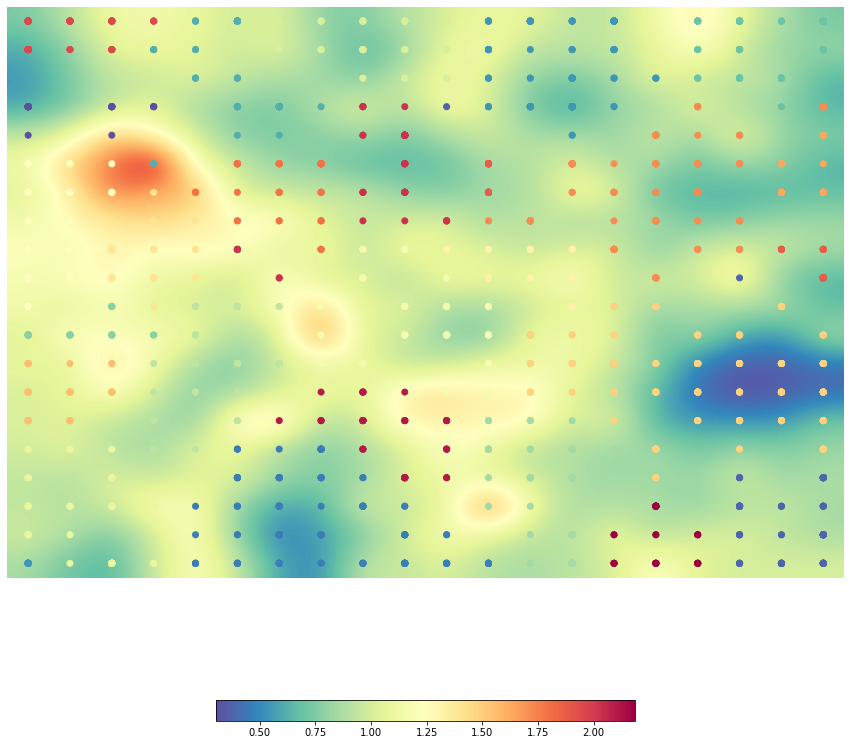

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
print(som20.clusters)

[[21 21 21 21  4  4  9  9  9  9  9  3  3  3  3  3  5  5  5  5]
 [21 21 21  4  4  4  9  9  9  9  9  3  3  3  3  3  5  5  5  5]
 [21 21  0  4  4  4  4  9  9  9  9  3  3  3  3  3  5  5  5  5]
 [ 0  0  0  0  4  4  4  4 22 22  1  3  3  3  3 18 18  5  5 18]
 [ 0  0  0  0  4  4  4 19 22 22 22 20  3  3 18 18 18 18 17 17]
 [12 12 12  4 19 19 19 19 22 22 20 20 20 18 18 18 18 18 17 17]
 [12 12 12 14 19 19 19 19 22 22 22 20 18 18 18 18 18 17 17 17]
 [12 12 14 14 14 19 19 19 22 22 22 18 18 18 18 18 18 18 17 17]
 [12 12 14 14 14 22 19 19 11 11 13 13 13 13 18 18 18 18 20 20]
 [12 12 14 14 14  8 22 11 11 11 11 13 13 13 13 18 18  1 20 20]
 [12  6  6 14  8  8  8 11 11 11 11 11 13 13 15 15 15 15 15 20]
 [ 6  6  6  6  8  8  8 11 11 11 11 11 15 15 15 15 15 15 15 15]
 [16 16 16  8  8  8  8 11 11 11 11 11 15 15 15 15 15 15 15 15]
 [16 16 16  8  8  8  8 23 23 23 11 11 15 15 15 15 15 15 15 15]
 [16 16 16  8  8  8 23 23 23 23 23  7  7  7 15 15 15 15 15 15]
 [10 10 10  8  8  2  2  2 23 23 23  7  7  7  7 15 15 15

In [ ]:
clusters, neurons_num = np.unique(som20.clusters, return_counts = True)
sorted_cluster_idxs = np.argsort(neurons_num)

print("Clusters sorted by inreasing number of neurons:")
print("Cluster index    :", sorted_cluster_idxs)
print("Number of neurons:", neurons_num[sorted_cluster_idxs])

Clusters sorted by inreasing number of neurons:
Cluster index    : [ 6  0 21 17 16 24 20 13 14 12 23  1  9 19  5 22  4 10  7  8  3 11 18  2
 15]
Number of neurons: [ 6  9  9  9  9  9 10 10 11 13 13 14 14 14 14 15 17 18 18 20 22 23 30 31
 42]


In [ ]:
cluster = 15
neurons_list = print_cluster_neurons_movies_report(cluster, som20, ubmus20)
neuron_movies_report(neurons_list, indices20)

Overall Cluster Genres stats:
[('Drama', 129), ('World cinema', 76), ('Comedy', 75), ('Romance Film', 46), ('Horror', 17), ('Japanese Movies', 17), ('Romantic drama', 15), ('Musical', 14), ('Adventure', 13), ('Crime Fiction', 13), ('Black-and-white', 13), ('Thriller', 13), ('Mystery', 12), ('Romantic comedy', 11), ('War film', 11), ('Parody', 11), ('Slapstick', 11), ('Art film', 10), ('Fantasy', 8), ('Short Film', 8), ('Family Film', 8), ("Children's/Family", 8), ('Chinese Movies', 8), ('Action', 7), ('Political drama', 7), ('Teen', 7), ('Family Drama', 6), ('Filipino Movies', 6), ('Indie', 6), ('Film adaptation', 6), ('Coming of age', 6), ('Comedy-drama', 6), ('Satire', 6), ('Television movie', 5), ('Period piece', 5), ('Childhood Drama', 4), ('Bollywood', 4), ('Melodrama', 4), ('Cult', 4), ('Psychological thriller', 4), ('Science Fiction', 3), ('Black comedy', 3), ('Historical Epic', 3), ('Sex comedy', 3), ('Comedy of manners', 3), ('Sports', 3), ('Road movie', 3), ('Political cinema

In [ ]:
cluster = 3
neurons_list = print_cluster_neurons_movies_report(cluster, som20, ubmus20)
neuron_movies_report(neurons_list, indices20)

Overall Cluster Genres stats:
[('Action/Adventure', 53), ('Drama', 51), ('Action', 46), ('Thriller', 46), ('Crime Fiction', 36), ('Comedy', 34), ('Crime Thriller', 22), ('Romance Film', 22), ('Indie', 17), ('Romantic comedy', 17), ('World cinema', 15), ('Adventure', 12), ('Mystery', 11), ('Western', 10), ('Romantic drama', 9), ('Action Thrillers', 8), ('Japanese Movies', 8), ('Gangster Film', 6), ('Science Fiction', 5), ('Chinese Movies', 5), ('Comedy-drama', 5), ('Fantasy', 5), ('Sports', 4), ('Buddy film', 4), ('Coming of age', 3), ('Film adaptation', 3), ('Martial Arts Film', 3), ('Heist', 3), ('Detective', 3), ('Period piece', 3), ('War film', 3), ('Black-and-white', 3), ('Black comedy', 3), ('Art film', 2), ('Detective fiction', 2), ('Suspense', 2), ('Family Film', 2), ('Slapstick', 2), ('Chase Movie', 2), ('Psychological thriller', 2), ('Horror', 2), ('Cult', 2), ('Auto racing', 1), ('Biker Film', 1), ('Courtroom Drama', 1), ('Americana', 1), ('Crime Drama', 1), ('Adventure Comed

In [ ]:
cluster = 7
neurons_list = print_cluster_neurons_movies_report(cluster, som20, ubmus20)
neuron_movies_report(neurons_list, indices20)

Overall Cluster Genres stats:
[('Drama', 53), ('Comedy', 40), ('Black-and-white', 40), ('Romance Film', 27), ('Family Film', 21), ('Horror', 17), ('Short Film', 15), ('World cinema', 12), ('Japanese Movies', 9), ('Fantasy', 8), ('Adventure', 7), ("Children's/Family", 6), ('Slapstick', 6), ('Mystery', 5), ('Comedy film', 5), ('Family Drama', 5), ('Thriller', 4), ('Melodrama', 4), ('Musical', 4), ('Television movie', 4), ('Comedy-drama', 3), ('War film', 3), ('Sports', 3), ("Children's", 3), ('Animal Picture', 3), ('Animation', 3), ('Crime Fiction', 3), ('Film adaptation', 2), ('Coming of age', 2), ('Filipino Movies', 2), ('Indie', 2), ('Family-Oriented Adventure', 2), ('Creature Film', 2), ('Zombie Film', 2), ('Comedy of Errors', 2), ('Chinese Movies', 2), ('Biography', 2), ('Adventure Comedy', 2), ('Western', 2), ('Crime Comedy', 1), ('Computer Animation', 1), ('Christian film', 1), ('Childhood Drama', 1), ('Biopic [feature]', 1), ('B-movie', 1), ('Anime', 1), ('Costume drama', 1), ('C

In [ ]:
cluster = 11
neurons_list = print_cluster_neurons_movies_report(cluster, som20, ubmus20)
neuron_movies_report(neurons_list, indices20)

Overall Cluster Genres stats:
[('Comedy', 53), ('Drama', 49), ('Romance Film', 38), ('Romantic drama', 27), ('Musical', 17), ('Action', 16), ('World cinema', 15), ('Bollywood', 12), ('Parody', 11), ('Film adaptation', 7), ('Crime Fiction', 7), ('Comedy film', 7), ('Adventure', 6), ('Science Fiction', 6), ('Coming of age', 6), ('Horror', 5), ('Short Film', 5), ('Fantasy', 5), ('War film', 5), ('Teen', 4), ('Thriller', 4), ('Political drama', 3), ('Family Film', 3), ('Satire', 3), ('Road movie', 2), ('Cult', 2), ('Melodrama', 2), ('Comedy of manners', 2), ('Romantic comedy', 2), ('Vampire movies', 2), ('Black comedy', 2), ('New Hollywood', 2), ('Black-and-white', 2), ('Period piece', 2), ('Chinese Movies', 2), ('Slasher', 2), ('Documentary', 1), ('Ensemble Film', 1), ('Action/Adventure', 1), ('Ealing Comedies', 1), ('Animated cartoon', 1), ('Bruceploitation', 1), ('Docudrama', 1), ('Art film', 1), ('Biography', 1), ('Epic', 1), ('Comedy-drama', 1), ('Comedy horror', 1), ('Zombie Film', 1

In [ ]:
cluster = 18
neurons_list = print_cluster_neurons_movies_report(cluster, som20, ubmus20)
neuron_movies_report(neurons_list, indices20)

Overall Cluster Genres stats:
[('Drama', 64), ('Action', 51), ('Romance Film', 51), ('World cinema', 49), ('Romantic drama', 44), ('Thriller', 40), ('Musical', 33), ('Bollywood', 29), ('Comedy', 28), ('Crime Fiction', 28), ('Adventure', 26), ('Action/Adventure', 19), ('Indie', 9), ('Mystery', 8), ('War film', 7), ('Black-and-white', 6), ('Action Thrillers', 6), ('Spy', 6), ('Science Fiction', 5), ('Western', 5), ('Horror', 5), ('Crime Comedy', 5), ('Period piece', 5), ('Detective', 4), ('Family Film', 4), ('Fantasy', 4), ('Martial Arts Film', 3), ('Film adaptation', 3), ('Romantic comedy', 3), ('Crime Thriller', 2), ('Black comedy', 2), ('Comedy-drama', 2), ('Detective fiction', 2), ('Comedy film', 2), ('Christian film', 2), ('Chinese Movies', 2), ('Family Drama', 2), ('Creature Film', 2), ('Fantasy Adventure', 2), ('History', 2), ('Teen', 2), ('Marriage Drama', 2), ('Biopic [feature]', 1), ('Costume Adventure', 1), ('Workplace Comedy', 1), ('Comedy of manners', 1), ('Comedy of Errors'

Αντίστοιχα με την προηγούμενη περίπτωση, παρατηρούμε πως, ακόμα και με μεγαλύτερο χάρτη και περισσότερα clusters, παρόλο που μερικά διαφορετικά clusters τείνουν να έχουν ταινίες παρόμοιων κατηγοριών, εν γένει οι τοπολογικές ιδιότητες παραμένουν εμφανείς. Πιο συγκεκριμένα, παρατηρούμε τα διαφορετικά είδη ταινιών που περιέχονται στα μακρινά clusters 15 και 3, αλλά και τα πολύ παρόμοια αντίστοιχα είδη που περιλαμβάνονται από γειτονιές clusters, όπως οι 7, 11, 15 και 3, 18. Επιπλέον, μια άλλη ενδιαφέρουσα διαπίστωση αφορά το γεγονός ότι, ενώ τα clusters 3, 15 είναι μακρινά, λόγω των διαφορετικών κατηγορίων που έχουν, το cluster 18, που είναι τοπολογικά ανάμεσα σε αυτά τα δύο clusters, περιλαμβάνει ταινίες που συνδυάζουν τις επιμέρους κατηγορίες τους (Drama, Action, Romance Film).

### Στη συνέχεια, θα επαναλάβουμε την παραπάνω διαδικασία με χάρτη 30x30 και clustering με k=30:

In [ ]:
n_rows, n_columns = 30, 30
som30 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som30.train(final_set, epochs = 100)

CPU times: user 7min 35s, sys: 2.31 s, total: 7min 37s
Wall time: 4min 5s


In [ ]:
bmus30 = som30.bmus
print(bmus30.shape)

ubmus30, indices30 = np.unique(bmus30, return_inverse=True, axis=0)
print(ubmus30)

(2000, 2)
[[ 0  0]
 [ 0  1]
 [ 0  2]
 ...
 [29 27]
 [29 28]
 [29 29]]


In [ ]:
som30.cluster(algorithm=KMeans(n_clusters=30, n_init=10))

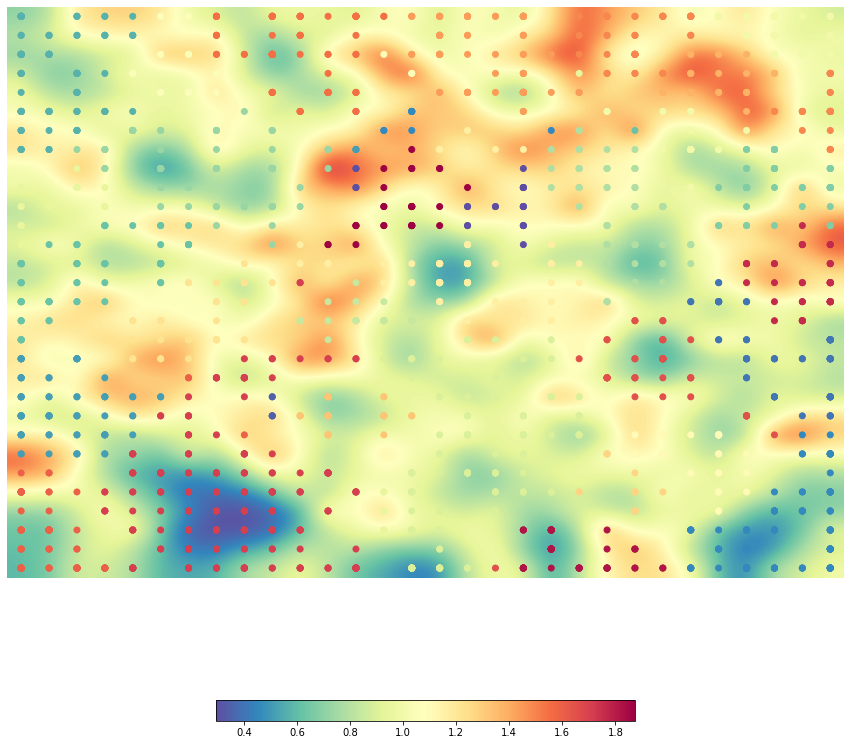

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som30.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
print(som30.clusters)

[[ 5  5  5  5  5 14 14 23 23 23 23 23 23 23 21 21 21 21 21 21 22 22 22 22
  22 13 13 13 13 13]
 [ 5  5  5  5  5 14 14 23 23 23 23 23 23 23 21 21 21 21 21 21 22 22 22 22
  22 13 13 13 13 13]
 [ 5  5  5  5 14 14 14 23 23 23 23 23 23 14 21 21 21 21 21 21 22 22 22 22
  20 20 20 13 13 13]
 [ 5  5  5  5 14 14 14 14 23 23 23 23 23 14 14 21 21 21 21 21 12 22 22 22
  20 20 20 20 13 22]
 [ 5  5  5  5 14 14 14 14 23 23 23 23 23 23  3 21 21 21 21 21 21 21 20 20
  20 20 20 20 22 22]
 [ 5  5  5  5  5 14 14  8  8 23 23 23 23  3  3  3 21 21 21 21 21 13 13 13
  13 20 20 22 22 22]
 [ 5  5  5  5  8  8  8  8  8  8  8  8  3  3  3  3 16 16  3  3  9  9  6 13
  13 13 13  7 22 22]
 [ 5  5  8  8  8  8  8  8  8  8  8  8  4  0 29 16 16 16 16  9  9  9  9 13
  13 13  7  7  7 22]
 [12 12 12  8  8  8  8  8  8  8  8  8  0 29 29 29 16 16  0  9  9  9  9  9
  13  7  7  7  7  7]
 [12 12 12 12  8  8  8  8  8  8  8  0  0 29 29 29 29  0  0  9  9  9  9  9
  13  7  7  7  7  7]
 [12 12 12 12 12  8  8  8  8  8  8  8 29 29 29 29 

In [ ]:
clusters, neurons_num = np.unique(som30.clusters, return_counts = True)
sorted_cluster_idxs = np.argsort(neurons_num)

print("Clusters sorted by inreasing number of neurons:")
print("Cluster index    :", sorted_cluster_idxs)
print("Number of neurons:", neurons_num[sorted_cluster_idxs])

Clusters sorted by inreasing number of neurons:
Cluster index    : [ 1 18 20  0 10 27 19 28 12 14 29 24 15  7 22 13  2 25 17  4  5 21 23  6
  9  3 16  8 11 26]
Number of neurons: [ 4 13 15 16 16 17 18 19 19 20 21 21 22 24 26 27 28 28 29 33 33 35 35 35
 42 45 45 49 78 87]


In [ ]:
cluster = 26
neurons_list = print_cluster_neurons_movies_report(cluster, som30, ubmus30)
neuron_movies_report(neurons_list, indices30)

Overall Cluster Genres stats:
[('Drama', 110), ('Comedy', 61), ('Romance Film', 56), ('Horror', 55), ('War film', 37), ('Science Fiction', 34), ('Comedy film', 31), ('Romantic comedy', 30), ('Slasher', 22), ('Cult', 19), ('Action', 18), ('Teen', 17), ('Mystery', 16), ('Indie', 15), ('Comedy-drama', 14), ('Crime Fiction', 11), ('B-movie', 11), ('Adventure', 11), ('Television movie', 10), ('Musical', 9), ('Satire', 9), ('Creature Film', 7), ('Black-and-white', 7), ('Parody', 7), ('Family Film', 6), ('Monster movie', 6), ('Action/Adventure', 6), ('Period piece', 6), ('Zombie Film', 6), ('Thriller', 5), ('Screwball comedy', 5), ('Film adaptation', 5), ('History', 5), ('Short Film', 5), ('Sex comedy', 5), ('Black comedy', 4), ('Coming of age', 4), ('Melodrama', 4), ('Docudrama', 4), ('Disaster', 4), ('Psychological thriller', 4), ('Political drama', 3), ('Film noir', 3), ('Horror Comedy', 3), ('Chinese Movies', 3), ("Children's/Family", 3), ('Fantasy', 3), ('Alien Film', 3), ('Comedy of man

In [ ]:
cluster = 3
neurons_list = print_cluster_neurons_movies_report(cluster, som30, ubmus30)
neuron_movies_report(neurons_list, indices30)

Overall Cluster Genres stats:
[('Drama', 59), ('Comedy', 41), ('Horror', 37), ('Romance Film', 25), ('Comedy film', 22), ('Science Fiction', 22), ('Comedy-drama', 22), ('Romantic drama', 12), ('Indie', 11), ('Crime Fiction', 10), ('Adventure', 10), ('Slasher', 10), ('World cinema', 9), ('Teen', 8), ('Satire', 8), ('Family Film', 7), ('Cult', 7), ('Family Drama', 6), ('Parody', 6), ('Coming of age', 5), ('Chinese Movies', 5), ('War film', 5), ('Black-and-white', 5), ('Creature Film', 4), ('Film adaptation', 4), ('Monster movie', 4), ('B-movie', 4), ('Thriller', 4), ('Television movie', 4), ('Romantic comedy', 4), ('Crime Comedy', 3), ('Political drama', 3), ('Slapstick', 3), ("Children's/Family", 3), ('Buddy film', 3), ('Horror Comedy', 3), ('Road movie', 3), ('Zombie Film', 3), ('Art film', 3), ('Period piece', 3), ('Melodrama', 3), ('Sex comedy', 2), ('Action', 2), ('Musical', 2), ('Ensemble Film', 2), ('Silent film', 2), ('Black comedy', 2), ('Martial Arts Film', 2), ('Animal Picture

In [ ]:
cluster = 22
neurons_list = print_cluster_neurons_movies_report(cluster, som30, ubmus30)
neuron_movies_report(neurons_list, indices30)

Overall Cluster Genres stats:
[('Drama', 94), ('Romance Film', 44), ('Romantic drama', 33), ('World cinema', 27), ('Crime Fiction', 21), ('Musical', 18), ('Bollywood', 13), ('Period piece', 9), ('Action', 8), ('Thriller', 8), ('Family Film', 7), ('Black-and-white', 6), ('Family Drama', 6), ('Political drama', 5), ('Indie', 5), ('Melodrama', 5), ('Adventure', 4), ('Coming of age', 4), ('Comedy', 4), ('Biopic [feature]', 4), ('Biography', 4), ('Christian film', 3), ('Japanese Movies', 3), ('Biographical film', 3), ('Art film', 3), ('Comedy film', 3), ('Crime Drama', 3), ("Children's/Family", 2), ('Short Film', 2), ('Television movie', 2), ('Fantasy', 2), ('Ensemble Film', 2), ('Media Satire', 2), ('Pre-Code', 2), ('Chinese Movies', 1), ('Childhood Drama', 1), ('British New Wave', 1), ('War film', 1), ('Christmas movie', 1), ('Anime', 1), ('Animation', 1), ('Animal Picture', 1), ('Americana', 1), ('Action/Adventure', 1), ('Comedy of Errors', 1), ('Satire', 1), ('Costume drama', 1), ('Marr

In [ ]:
cluster = 14
neurons_list = print_cluster_neurons_movies_report(cluster, som30, ubmus30)
neuron_movies_report(neurons_list, indices30)

Overall Cluster Genres stats:
[('Drama', 72), ('World cinema', 42), ('Crime Fiction', 25), ('Bollywood', 16), ('Romantic drama', 16), ('Romance Film', 16), ('Thriller', 15), ('Crime Thriller', 11), ('Musical', 11), ('Mystery', 10), ('Adventure', 9), ('Film adaptation', 9), ('Indie', 9), ('Action', 7), ('Political drama', 6), ('Comedy', 6), ('Action/Adventure', 5), ('Black-and-white', 5), ('War film', 4), ('Period piece', 3), ('Melodrama', 3), ('Suspense', 3), ('Psychological thriller', 3), ('Chinese Movies', 3), ('New Hollywood', 2), ('Science Fiction', 2), ('Epic', 2), ('Television movie', 2), ('Caper story', 1), ('Chase Movie', 1), ('Costume Adventure', 1), ('Black comedy', 1), ('Childhood Drama', 1), ('Biographical film', 1), ('Vampire movies', 1), ('Comedy film', 1), ('Addiction Drama', 1), ('Comedy-drama', 1), ('Coming of age', 1), ('Detective', 1), ('Costume drama', 1), ('Film noir', 1), ('Music', 1), ('Kitchen sink realism', 1), ('Japanese Movies', 1), ('Horror', 1), ('Heist', 1

In [ ]:
cluster = 8
neurons_list = print_cluster_neurons_movies_report(cluster, som30, ubmus30)
neuron_movies_report(neurons_list, indices30)

Overall Cluster Genres stats:
[('Drama', 142), ('Romance Film', 44), ('World cinema', 31), ('Crime Fiction', 28), ('Thriller', 27), ('Black-and-white', 25), ('Family Drama', 21), ('Romantic drama', 20), ('Comedy', 17), ('Japanese Movies', 14), ('Art film', 12), ('Film adaptation', 9), ('Musical', 9), ('Action', 9), ('Romantic comedy', 9), ('Comedy-drama', 7), ('Action/Adventure', 6), ('Adventure', 6), ('Pre-Code', 6), ('Coming of age', 5), ('Crime Drama', 5), ('Family Film', 5), ('Indie', 4), ('Bollywood', 4), ('Fantasy', 4), ('Chinese Movies', 3), ('Ensemble Film', 3), ('Road movie', 3), ('Western', 3), ('Horror', 3), ('Period piece', 3), ('Mystery', 3), ('Melodrama', 3), ('War film', 2), ('Domestic Comedy', 2), ("Children's", 2), ('Comedy of manners', 2), ('Prison', 2), ('Tragedy', 2), ('Teen', 2), ('Television movie', 2), ('Sports', 2), ('Satire', 2), ('Psychological thriller', 2), ('Film noir', 2), ('Media Satire', 2), ('Silent film', 2), ('Americana', 1), ('Political drama', 1), (

In [ ]:
cluster = 23
neurons_list = print_cluster_neurons_movies_report(cluster, som30, ubmus30)
neuron_movies_report(neurons_list, indices30)

Overall Cluster Genres stats:
[('Drama', 152), ('Romance Film', 52), ('Crime Fiction', 51), ('Romantic drama', 46), ('World cinema', 45), ('Thriller', 33), ('Crime Thriller', 18), ('Indie', 16), ('Period piece', 13), ('Action', 12), ('Coming of age', 11), ('Horror', 11), ('War film', 10), ('Bollywood', 9), ('Musical', 9), ('Mystery', 9), ('Comedy', 8), ('Family Drama', 8), ('Film adaptation', 7), ('Adventure', 7), ('Family Film', 7), ('Biography', 6), ('Psychological thriller', 6), ('Television movie', 6), ('Teen', 5), ('Filipino Movies', 5), ('Fantasy', 5), ('Political drama', 4), ('Docudrama', 4), ('Romantic comedy', 4), ('Film noir', 4), ('Action/Adventure', 4), ('Melodrama', 4), ('Biopic [feature]', 4), ('Sports', 3), ('Historical Epic', 3), ('Chinese Movies', 3), ('Christian film', 3), ('Comedy film', 3), ('Social problem film', 3), ('Black-and-white', 3), ('Japanese Movies', 3), ('Biographical film', 3), ('Suspense', 3), ('Art film', 3), ('Gangster Film', 2), ('Courtroom Drama', 

Στο συγκεκριμένο παράδειγμα παρατηρούμε πως, λόγω του αυξημένου μεγέθους του χάρτη και του αριθμού των clusters, το clustering που πραγματοποιείται καταλήγει σε αρκετά παρόμοια clusters, τα οποία διαφοροποιούνται ως προς μερικά, όχι και τόσο συχνά, είδη ταινιών. Αξιοσημείωτο είναι το γεγονός πως στη συντριπτική πλειοψηφία των clusters η κατηγορία των ταινιών που κυριαρχεί είναι η Drama. Στις επόμενες κατηγορίες υπάρχει μια μικρή διαφοροποίηση, καθώς άλλες είναι κυρίως Romance Film, ενώ άλλες πχ Crime Fiction και Thriller. Όπως έχει αναφερθεί και στην εκφώνηση παραπάνω αυτό είναι αναμενόμενο, καθώς μεγάλος αριθμός clusters (30 στη συγκεκριμένη περίπτωση) οδηγεί στη δημιουργία υπο-clusters από τα αρχικά clusters, που θα ανιχνεύονταν με μικρότερο k. Επιπλέον, άλλος ένας καθοριστικός παράγοντας που οδήγησε σε αυτό το clustering είναι το γεγονός ότι δουλεύουμε με ένα υποσύνολο του αρχικού dataset (2000 από τις 5000 ταινίες) χωρίς να βεβαιωθούμε πως υπάρχει επαρκής εκπροσώπηση όλων των ειδών του αρχικού dataset, καθώς λαμβάνουμε υπόψιν απλά τις 2000 πρώτες ταινίες. Αυτό γίνεται αντιληπτό και στο σημείο που εξάγουμε τα στατιστικά του dataset, καθώς κατηγορίες όπως οι Drama, Comedy και Romance Film κυριαρχούν σε σχέση με τις υπόλοιπες.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>